In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image

sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.sentiment_engine import SentimentEngine
from src.plotting import Visualizer
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Variable Configuration for Intended Analysis

TICKER = "BTC-USD"
START_DATE = "2021-01-01"
END_DATE = "2023-01-01"
SAMPLE_FRAC = 0.20 
CACHE_FILE = "../data/daily_sentiment_cache.csv"

In [4]:
loader = DataLoader()

# 1. Fetch Crypto Data
print(f"Fetching {TICKER} data...")
crypto_df = loader.fetch_crypto_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE)

# 2. Check for Cached Sentiment Data
if os.path.exists(CACHE_FILE):
    print("Found cached sentiment data! Loading from CSV...")
    daily_sentiment = pd.read_csv(CACHE_FILE, index_col=0, parse_dates=True)
else:
    print("No cache found. Processing tweets from scratch...")
    tweets_df = loader.load_tweets_csv("../data/tweets.csv", sample_fraction=SAMPLE_FRAC)
    
    engine = SentimentEngine()
    daily_sentiment = engine.process_tweets(tweets_df)    
    daily_sentiment.to_csv(CACHE_FILE)
    print(f"Sentiment data saved to {CACHE_FILE}")

print(f"Loaded {len(daily_sentiment)} days of sentiment data.")

Fetching BTC-USD data...
Fetching BTC-USD data from 2021-01-01 to 2023-01-01...
Found cached sentiment data! Loading from CSV...
Loaded 222 days of sentiment data.


In [5]:
# Merge the cached sentiment with the specific crypto ticker

engine = SentimentEngine() 
final_df = engine.merge_data(daily_sentiment, crypto_df)

print("\n--- Data Sample ---")
display(final_df.head())

final_df.to_csv(f"../output/final_data_{TICKER}.csv")

Merging Sentiment and Crypto data...

--- Data Sample ---


,sentiment_score,tweet_volume,Close,Volume,Volatility
2021-02-05,0.125486,358,38144.308594,58598066402,0.035073
2021-02-06,0.135948,636,39266.011719,71326033653,0.034495
2021-02-07,0.142059,593,38903.441406,65500641143,0.028917
2021-02-08,0.148178,1077,46196.464844,101467222687,0.067552
2021-02-09,0.163600,874,46481.105469,91809846886,0.069136


In [6]:
print("--- DIAGNOSTIC REPORT ---")
print(f"1. Current Working Directory: {os.getcwd()}")

# Check if 'data' folder exists in current location
if os.path.exists("data"):
    print("2. 'data' folder FOUND in current directory.")
    print(f"3. Files in 'data': {os.listdir('data')}")
else:
    print("2. 'data' folder NOT found here.")
    
# Check if 'data' folder exists one level up
if os.path.exists("../data"):
    print("2. '../data' folder FOUND one level up (Correct for Notebooks).")
    print(f"3. Files in '../data': {os.listdir('../data')}")
else:
    print("2. '../data' folder NOT found one level up.")

--- DIAGNOSTIC REPORT ---
1. Current Working Directory: c:\Users\amsya\OneDrive\Desktop\Job Hunting\Graduate Program\Projects\investments\crypto-sentiment-causality-analysis\notebooks
2. 'data' folder NOT found here.
2. '../data' folder FOUND one level up (Correct for Notebooks).
3. Files in '../data': ['daily_sentiment_cache.csv', 'tweets.csv']


Generating Sentiment vs. Price chart...
Saved to ../output/price_vs_sentiment.png


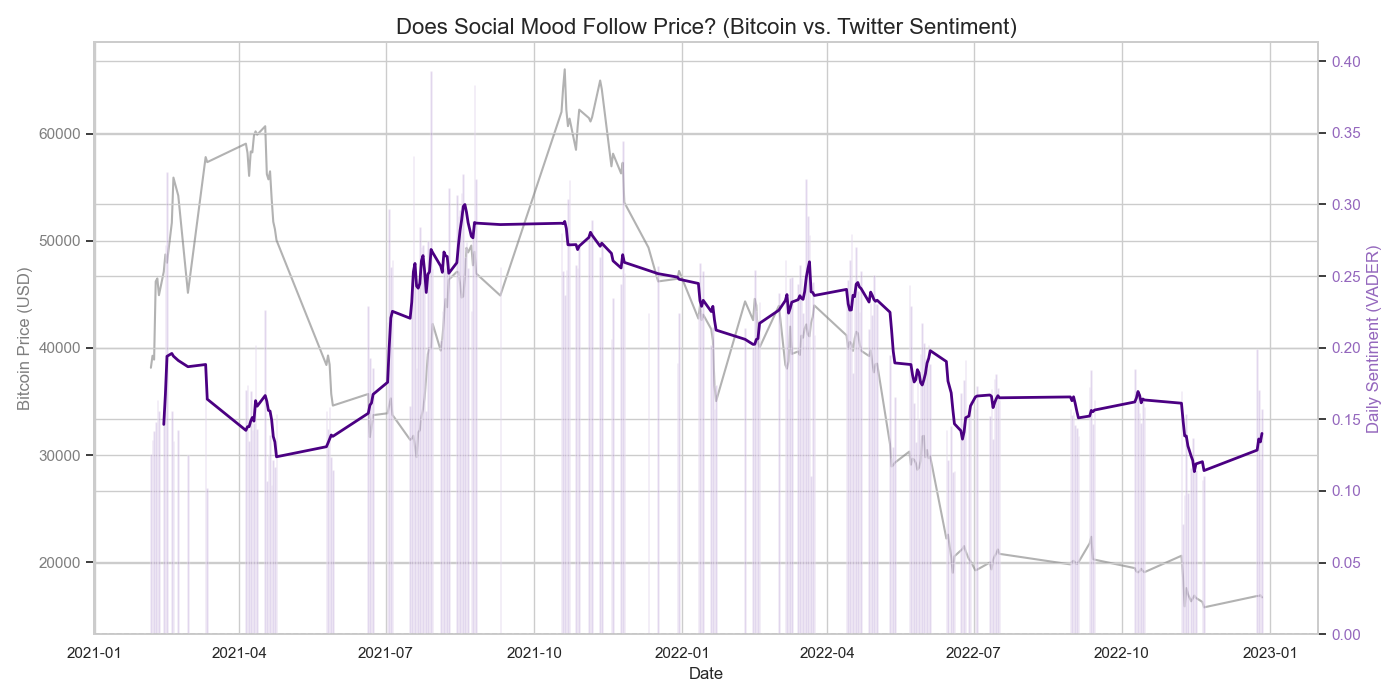

Generating Correlation Heatmap...
Saved to ../output/correlation_matrix.png


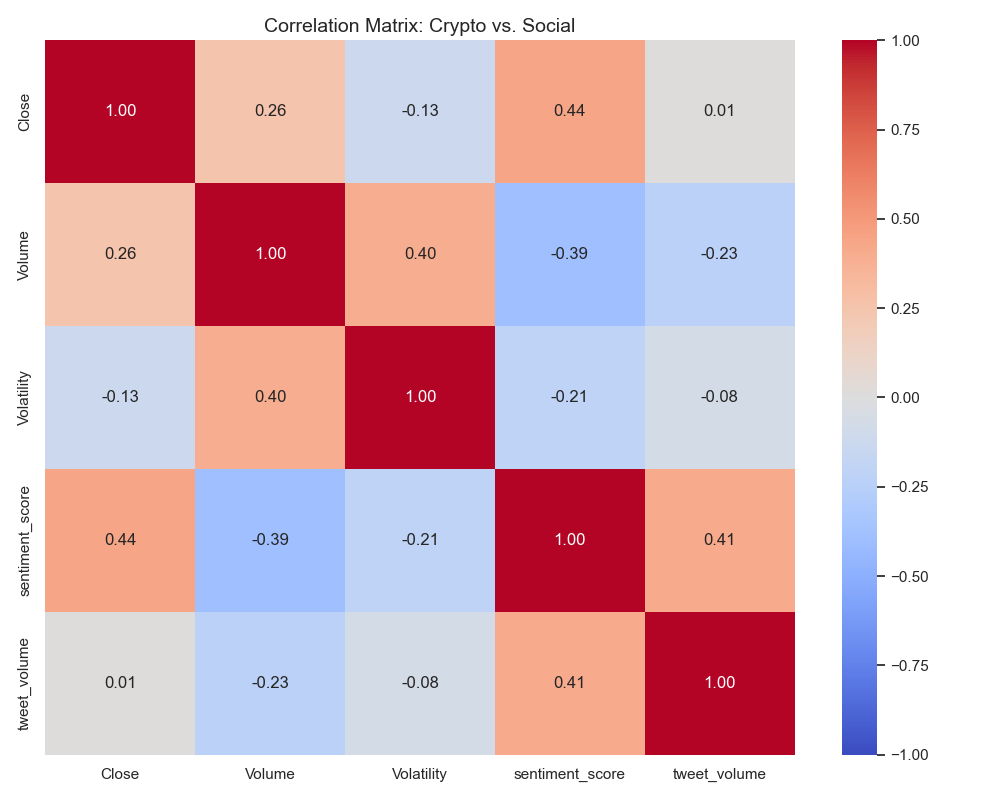

In [7]:
viz = Visualizer()

# Plot 1: Price vs. Sentiment
viz.plot_sentiment_vs_price(final_df)
display(Image(filename='../output/price_vs_sentiment.png'))

# Plot 2: Correlation Heatmap
viz.plot_correlation_heatmap(final_df)
display(Image(filename='../output/correlation_matrix.png'))

In [8]:
print(f"--- Granger Causality Test for {TICKER} ---")

# HYPOTHESIS 1: Does Sentiment predict Volatility?
print("\n>>> TEST 1: Sentiment Score -> Volatility")
try:
    grangercausalitytests(final_df[['Volatility', 'sentiment_score']], maxlag=5)
except Exception as e:
    print("Not enough data for Test 1.")

# HYPOTHESIS 2: Does Volume predict Volatility? (The 'Crowd Noise' Theory)
print("\n>>> TEST 2: Tweet Volume -> Volatility")
try:
    grangercausalitytests(final_df[['Volatility', 'tweet_volume']], maxlag=5)
except Exception as e:
    print("Not enough data for Test 2.")

--- Granger Causality Test for BTC-USD ---

>>> TEST 1: Sentiment Score -> Volatility

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3603  , p=0.2448  , df_denom=214, df_num=1
ssr based chi2 test:   chi2=1.3793  , p=0.2402  , df=1
likelihood ratio test: chi2=1.3750  , p=0.2410  , df=1
parameter F test:         F=1.3603  , p=0.2448  , df_denom=214, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6913  , p=0.5020  , df_denom=211, df_num=2
ssr based chi2 test:   chi2=1.4154  , p=0.4928  , df=2
likelihood ratio test: chi2=1.4108  , p=0.4939  , df=2
parameter F test:         F=0.6913  , p=0.5020  , df_denom=211, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7550  , p=0.5206  , df_denom=208, df_num=3
ssr based chi2 test:   chi2=2.3411  , p=0.5047  , df=3
likelihood ratio test: chi2=2.3285  , p=0.5071  , df=3
parameter F test:         F=0.7550  , p=0.5206  , df_denom=208, df_num=3

Granger

--- DIAGRAM 1: Do Tweets predict Volatility? ---


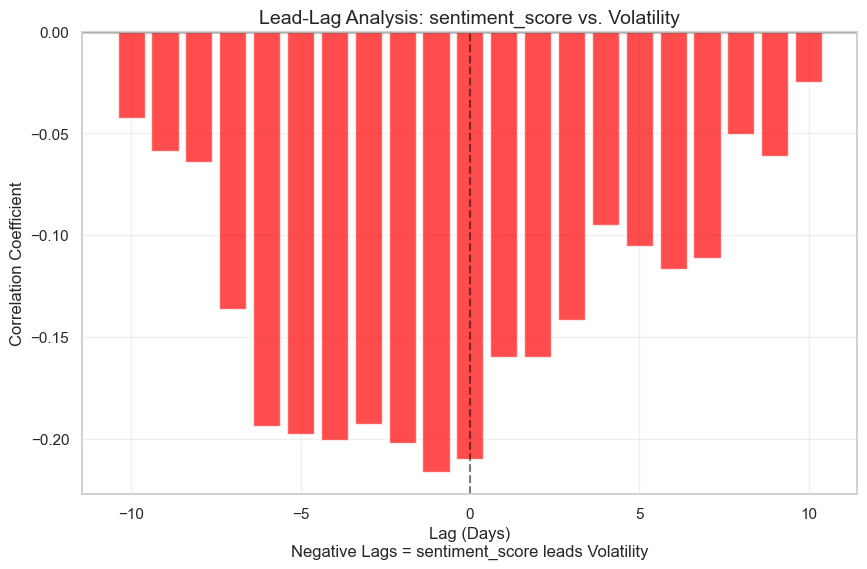

--- DIAGRAM 2: Does VOLUME predict Volatility? ---


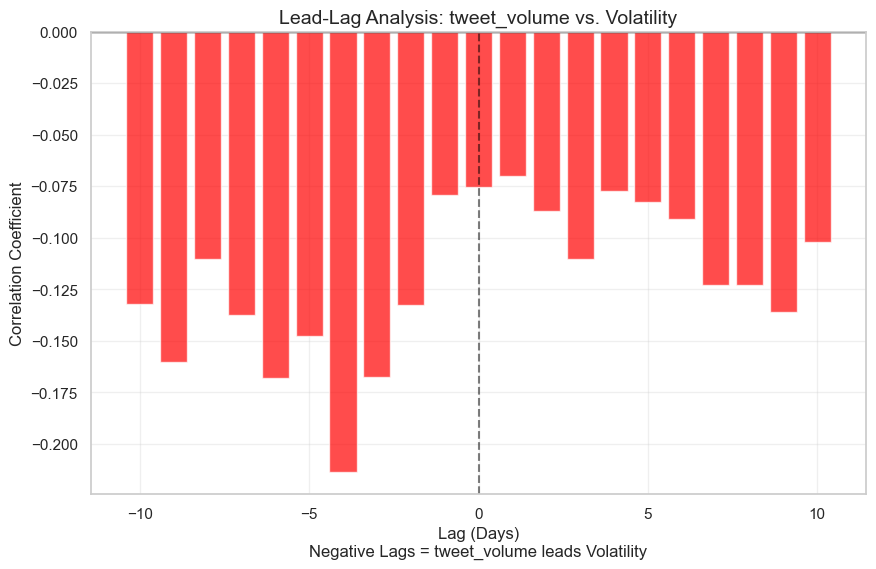

In [9]:
# Lead-Lag Cross-Correlation Analysis

def plot_cross_correlation(df, x_col, y_col, max_lag=10):
    """
    Plots the Cross-Correlation Function (CCF) to visualize Lead-Lag effects.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate cross-correlation
    d1 = df[x_col]
    d2 = df[y_col]
    
    # Normalize (Standard Score) for valid correlation comparison
    d1 = (d1 - d1.mean()) / d1.std()
    d2 = (d2 - d2.mean()) / d2.std()
    
    # Compute correlation at different lags
    lags = np.arange(-max_lag, max_lag + 1)
    corrs = [d1.corr(d2.shift(lag)) for lag in lags]
    
    # Plot
    colors = ['red' if c < 0 else 'green' for c in corrs]
    ax.bar(lags, corrs, color=colors, alpha=0.7)    
    ax.set_title(f'Lead-Lag Analysis: {x_col} vs. {y_col}', fontsize=14)
    ax.set_xlabel(f'Lag (Days)\nNegative Lags = {x_col} leads {y_col}', fontsize=12)
    ax.set_ylabel('Correlation Coefficient', fontsize=12)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.show()

print("--- DIAGRAM 1: Do Tweets predict Volatility? ---")
plot_cross_correlation(final_df, 'sentiment_score', 'Volatility')

print("--- DIAGRAM 2: Does VOLUME predict Volatility? ---")
plot_cross_correlation(final_df, 'tweet_volume', 'Volatility')

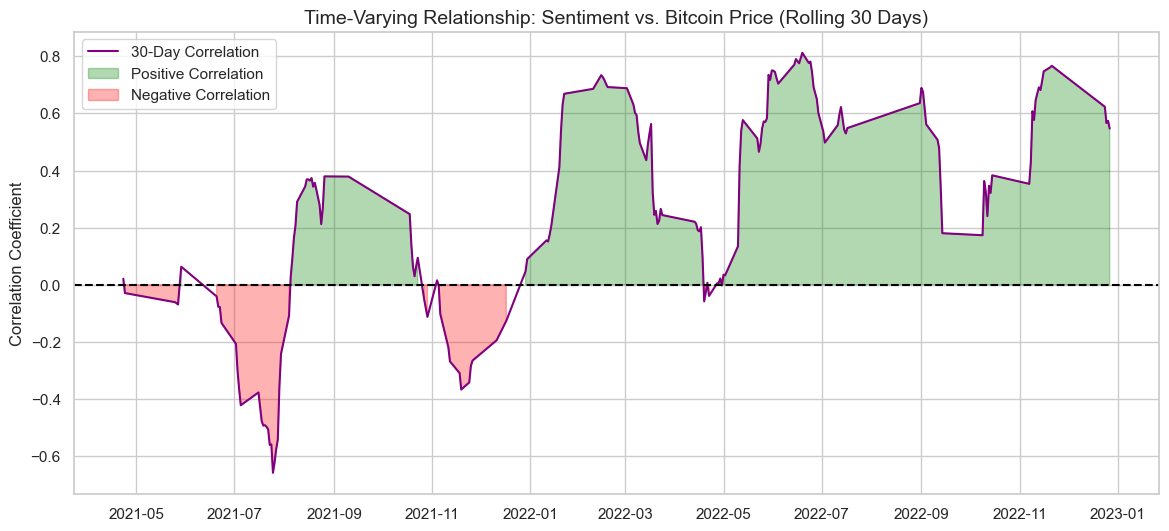

In [10]:
# Rolling Correlation Analysis

window_size = 30
final_df['Rolling_Corr'] = final_df['sentiment_score'].rolling(window=window_size).corr(final_df['Close'])

plt.figure(figsize=(14, 6))
plt.plot(final_df.index, final_df['Rolling_Corr'], color='purple', label=f'{window_size}-Day Correlation')
plt.axhline(0, color='black', linestyle='--')
plt.fill_between(final_df.index, final_df['Rolling_Corr'], 0, where=(final_df['Rolling_Corr'] > 0), color='green', alpha=0.3, label='Positive Correlation')
plt.fill_between(final_df.index, final_df['Rolling_Corr'], 0, where=(final_df['Rolling_Corr'] < 0), color='red', alpha=0.3, label='Negative Correlation')
plt.title(f'Time-Varying Relationship: Sentiment vs. Bitcoin Price (Rolling {window_size} Days)', fontsize=14)
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.show()

--- TOP 5 MARKET CRASHES & SOCIAL MOOD ---


,Close,Volatility,sentiment_score,tweet_volume
2021-05-25,38402.222656,0.094885,0.156021,531
2022-11-10,17586.771484,0.084602,0.153715,2720
2022-11-14,16618.199219,0.080660,0.136901,2633
2022-06-19,20553.271484,0.080431,0.114073,2827
2022-11-11,17034.292969,0.079947,0.098760,3644


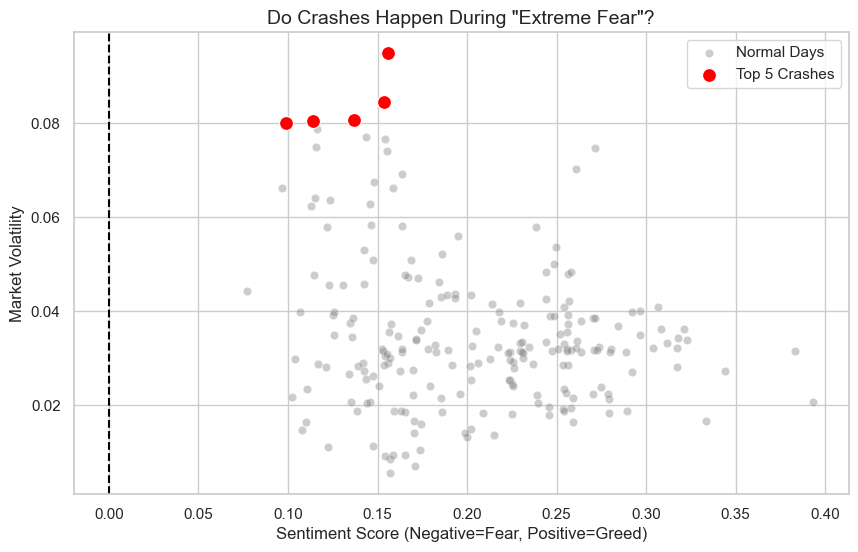

In [11]:
# Identify the Top 5 Most Volatile Days
top_volatility_days = final_df.nlargest(5, 'Volatility')

print("--- TOP 5 MARKET CRASHES & SOCIAL MOOD ---")
display(top_volatility_days[['Close', 'Volatility', 'sentiment_score', 'tweet_volume']])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='sentiment_score', y='Volatility', color='grey', alpha=0.4, label='Normal Days')
sns.scatterplot(data=top_volatility_days, x='sentiment_score', y='Volatility', color='red', s=100, label='Top 5 Crashes')
plt.title('Do Crashes Happen During "Extreme Fear"?', fontsize=14)
plt.xlabel('Sentiment Score (Negative=Fear, Positive=Greed)')
plt.ylabel('Market Volatility')
plt.axvline(0, linestyle='--', color='black')
plt.legend()
plt.show()